In [1]:
import logging

logger = logging.getLogger(__name__)
logger.setLevel(level = logging.INFO)
handler = logging.FileHandler("log/bp-13.log")
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
import os, sys, time
import pandas as pd
import numpy as np

attr_dict = {"surgery": 1,
 "Age": 1,
 "Hospital Number": 1,
 "rectal temperature": 0,
 "pulse": 0,
 "respiratory rate": 0,
 "temperature of extremities": 1,
 "peripheral pulse": 1,
 "mucous membranes": 1,
 "capillary refill time": 1,
 "pain": 1,
 "peristalsis": 1,
 "abdominal distension": 1,
 "nasogastric tube": 1,
 "nasogastric reflux": 1,
 "nasogastric reflux PH": 0,
 "rectal examination": 1,
 "abdomen": 1,
 "packed cell volume": 0,
 "total protein": 0,
 "abdominocentesis appearance": 1,
 "abdomcentesis total protein": 0,
 "outcome": 1,
 "surgical lesion": 1,
 "type of lesion 1": 1,
 "type of lesion 2": 1,
 "type of lesion 3": 1,
 "cp_data": 1} # 0: continuous, 1: discrete

train_data = pd.read_csv("horse-colic.data",names=attr_dict.keys(),index_col=False,delim_whitespace=True)
test_data = pd.read_csv("horse-colic.test",names=attr_dict.keys(),index_col=False,delim_whitespace=True)
# for a in train_data.columns.values:
#     print(train_data[a].value_counts())

def preprocessing(data):
    """
    Select some useful attributes
    """
    attributes = []
    for a in data.columns.values:
        in_flag = attr_dict.get(a,None)
        if in_flag == None: # newly appended
            attributes.append(a)
        elif in_flag == 0: # continuous
            # data[a] = (data[a] - data[a].mean()) / data[a].std() # normalization
            attributes.append(a)
        else: # discrete, no need to append
            pass
    df = data[attributes]
    return df
    # normalized_df = (df-df.mean())/df.std() # (df.max()-df.min())
    # return normalized_df

def fill_data(data,flag=1):
    """
    Fill in missing data (?)
    """
    for a in data.columns.values:
        if a in ["type of lesion 1","type of lesion 2", "type of lesion 3","Hospital Number"]: # remove
            continue
        if data[a].dtype != np.int64: # has ?
            have_data = data[data[a] != "?"][a]
            if attr_dict[a]: # discrete
                data.loc[data[a] == "?",a] = have_data.value_counts().idxmax() # view or copy? Use loc!
                if a != "outcome":
                    data[a] = pd.Categorical(data[a])
                    dummies = pd.get_dummies(data[a],prefix="{}_category".format(a))
                    data = pd.concat([data,dummies],axis=1)
            else: # continuous
                data.loc[data[a] == "?",a] = np.mean(have_data.astype(np.float))
        elif attr_dict[a]:
            data[a] = pd.Categorical(data[a])
            dummies = pd.get_dummies(data[a],prefix="{}_category".format(a))
            data = pd.concat([data,dummies],axis=1)
    return data.astype(np.float)

# Data cleaning
data = pd.concat([train_data,test_data],axis=0)
data = fill_data(data,1)
label = data["outcome"].astype(np.float)
train_label, test_label = label[:len(train_data)], label[len(train_data):]
train_label /= 3
train_data, test_data = data[:len(train_data)], data[len(train_data):]
train_data = preprocessing(train_data)
test_data = preprocessing(test_data)
# data = preprocessing(data)
# train_data, test_data = data[:len(train_data)], data[len(train_data):]
print(train_data.columns)
print(len(train_data.columns))

Index(['rectal temperature', 'pulse', 'respiratory rate',
       'nasogastric reflux PH', 'packed cell volume', 'total protein',
       'abdomcentesis total protein', 'surgery_category_1',
       'surgery_category_2', 'Age_category_1', 'Age_category_9',
       'temperature of extremities_category_1',
       'temperature of extremities_category_2',
       'temperature of extremities_category_3',
       'temperature of extremities_category_4', 'peripheral pulse_category_1',
       'peripheral pulse_category_2', 'peripheral pulse_category_3',
       'peripheral pulse_category_4', 'mucous membranes_category_1',
       'mucous membranes_category_2', 'mucous membranes_category_3',
       'mucous membranes_category_4', 'mucous membranes_category_5',
       'mucous membranes_category_6', 'capillary refill time_category_1',
       'capillary refill time_category_2', 'capillary refill time_category_3',
       'pain_category_1', 'pain_category_2', 'pain_category_3',
       'pain_category_4', 'pai

In [3]:
import nn
import time
import pickle

def get_batches(data,label,batch_size=1):
    num_batches = len(data) // batch_size
    for i in range(0,num_batches,batch_size):
        yield data[i:i+batch_size].to_numpy(), label[i:i+batch_size].to_numpy().reshape(-1,1)

def train(net,max_iter=1000):
    """
    Train the network
    """
    start_time = time.time()
    loss_history, accuracy_history = [], []
    losses = []
    for i in range(max_iter):
        net.train()

        batches = get_batches(train_data,train_label,16) # generator
        for x, y in batches:
            Y_hat = net.forward(x)
            loss = net.MSE(Y_hat, y)
            losses.append(loss)
            net.backward(Y_hat,y)

        if (i+1) % 1000 == 0:
            avg_loss = np.array(losses).mean()
            loss_history.append(avg_loss)
            losses = []
            acc = test(net,test_data,test_label)
            accuracy_history.append(acc)
            # Early syop
            # if len(accuracy_history) >= 3 and accuracy_history[-1] <= accuracy_history[-2] <= accuracy_history[-3]:
            #     logger.info("Early stop at iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            #     print("Early stop at iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            #     break
            logger.info("Iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            print("Iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            if acc == max(accuracy_history):
                with open("checkpoint/nn-best.pkl","wb") as netfile:
                    pickle.dump(net,netfile)
        if (i+1) % 10000 == 0:
            with open("checkpoint/nn-{}.pkl".format(i+1),"wb") as netfile:
                pickle.dump(net,netfile)
                
    print("Time: {}s".format(time.time() - start_time))
    return loss_history, accuracy_history

In [4]:
def test(net,test_X,test_y):
    """
    Test the network
    """
    cnt = 0
    for j, x in test_X.iterrows():
        net.eval()
        Y_hat = net.forward(x.to_numpy().reshape(1,-1))
        predicted = np.argmin(abs(np.array([1/3,2/3,1]) - Y_hat)) + 1
        # print(Y_hat,predicted)
        y = np.array([test_y[j]])
        if predicted == y:
            cnt += 1
    return cnt / len(test_X)

In [5]:
net = nn.Network(len(train_data.columns.values),16,1,0.001)
# with open("checkpoint/nn-5000.pkl","rb") as netfile:
#     net = pickle.load(netfile)
loss_history, accuracy_history = train(net,100000)

Iter 1000/100000 Loss: 0.8843274067916168 Accuracy: 29.411764705882355%
Iter 2000/100000 Loss: 0.8538749577728156 Accuracy: 36.76470588235294%
Iter 3000/100000 Loss: 0.8342712563730031 Accuracy: 52.94117647058824%
Iter 4000/100000 Loss: 0.8140362127667813 Accuracy: 60.29411764705882%
Iter 5000/100000 Loss: 0.8013842019273675 Accuracy: 61.76470588235294%
Iter 6000/100000 Loss: 0.7891238534362846 Accuracy: 60.29411764705882%
Iter 7000/100000 Loss: 0.7760313948706073 Accuracy: 60.29411764705882%
Iter 8000/100000 Loss: 0.7657202831407838 Accuracy: 63.23529411764706%
Iter 9000/100000 Loss: 0.7570592418831991 Accuracy: 63.23529411764706%
Iter 10000/100000 Loss: 0.7492987525608475 Accuracy: 63.23529411764706%
Iter 11000/100000 Loss: 0.7421983552930916 Accuracy: 66.17647058823529%
Iter 12000/100000 Loss: 0.7356557949872194 Accuracy: 66.17647058823529%
Iter 13000/100000 Loss: 0.7296045835445921 Accuracy: 66.17647058823529%
Iter 14000/100000 Loss: 0.7239952437571071 Accuracy: 66.17647058823529%


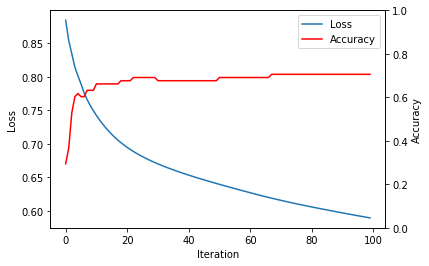

In [6]:
"""
Plot the train loss curve
"""
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(loss_history,label="Loss")
ax2 = ax.twinx()
lns2 = ax2.plot(accuracy_history,"-r",label="Accuracy")

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=0)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

plt.savefig(r"fig/iteration.pdf",format="pdf",dpi=200)
plt.show()

In [7]:
test(net,train_data,train_label*3)

0.6066666666666667